In [1]:
# Import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Read the data from CSV file
diabetic_data_file_id = '1ejHP33zthzxnr1p-ZXjxHsGcTiUm2quf'
ids_mapping_file_id = '1uZzE6xZUqYbCPIDjMnFZTbq-O1OFaklc'

google_drive_url = 'https://drive.google.com/uc?export=download&id={file_id}'

# Load the data
diabetic_data = pd.read_csv(google_drive_url.format(file_id = diabetic_data_file_id))
ids_mapping = pd.read_csv(google_drive_url.format(file_id = ids_mapping_file_id))

# Part 1: Building up a basic predictive model

In [3]:
# Show the shape of the data.

diabetic_data_shape = diabetic_data.shape
ids_mapping_shape = ids_mapping.shape

(diabetic_data_shape, ids_mapping_shape)

((101766, 50), (67, 2))

In [4]:
# Delete the column 'encounter_id' from the diabetic data
diabetic_data_cleaned = diabetic_data.drop(columns=['encounter_id'])

# Show the new shape of the data to confirm deletion
new_shape = diabetic_data_cleaned.shape
new_shape

(101766, 49)

In [5]:
# Summary of missing values before replacement
missing_before = diabetic_data.isin(['?']).sum()
missing_before

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [6]:
# Identify missing values represented by '?'
diabetic_data_cleaned = diabetic_data_cleaned.replace('?', pd.NA)

# Get the count of missing values for each column
missing_after = diabetic_data_cleaned.isna().sum()
missing_after

patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

In [7]:
# Convert the 'readmitted' feature to binary
diabetic_data_cleaned['readmitted'] = diabetic_data_cleaned['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0})

# Show the value counts of the updated 'readmitted' feature to confirm the conversion
readmitted_value_counts = diabetic_data_cleaned['readmitted'].value_counts()
readmitted_value_counts

0    90409
1    11357
Name: readmitted, dtype: int64

In [8]:
# Check the datatype of each column
column_data_types = diabetic_data_cleaned.dtypes
column_data_types

patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

In [9]:
# Calculate the percentage of missing values for each column
missing_percentage = (diabetic_data_cleaned.isna().sum() / len(diabetic_data_cleaned)) * 100

# List columns with more than 90% missing values
columns_to_drop = missing_percentage[missing_percentage > 90].index
columns_to_drop

Index(['weight'], dtype='object')

In [10]:
# Drop columns with more than 90% missing values
diabetic_data_reduced = diabetic_data_cleaned.drop(columns=columns_to_drop)

# New percentage of missing values after dropping the columns
new_missing_percentage = (diabetic_data_reduced.isna().sum() / len(diabetic_data_reduced)) * 100
new_missing_percentage

patient_nbr                  0.000000
race                         2.233555
gender                       0.000000
age                          0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropamide               0.000000
glimepiride 

In [11]:
# List of columns with near zero variance
near_zero_variance_columns = [
    'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone'
]

# Delete the specified near zero-variance columns
diabetic_data_final = diabetic_data_reduced.drop(columns=near_zero_variance_columns)

# Show the new shape of the data to confirm the deletion
final_shape = diabetic_data_final.shape
final_shape

(101766, 31)

In [12]:
missing_after = diabetic_data_final.isna().sum()
missing_after

patient_nbr                     0
race                         2273
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
glipizide                       0
glyburide                       0
pioglitazone                    0
rosiglitazone                   0
insulin                         0
change                          0
diabetesMed   

In [13]:
# Drop 'payer_code' as it has too many missing columns and 'patient_nbr' is irrelevant to predicting
diabetic_data_final = diabetic_data_final.drop(columns=['payer_code', 'patient_nbr'])

# Show the new shape of the data to confirm the deletion
final_shape_after_drop = diabetic_data_final.shape
final_shape_after_drop

(101766, 29)

In [14]:
# Replace null values with 'Other' in 'race' column before dropping rows
# Replace null values with 'Unknown' in 'medical_specialty' column before dropping rows
# to retain more of dataset
diabetic_data_final['race'] = diabetic_data_final['race'].fillna('Other')
diabetic_data_final['medical_specialty'] = diabetic_data_final['medical_specialty'].fillna('Unknown')

# Then drop rows with any remaining null values
diabetic_data_final_filled_cleaned = diabetic_data_final.dropna()

# Show the new shape of the data to confirm row deletion
final_filled_cleaned_shape = diabetic_data_final_filled_cleaned.shape
final_filled_cleaned_shape

(100244, 29)

In [15]:
# Display the summary statistics of the numerical columns
numerical_summary = diabetic_data_final_filled_cleaned.describe()
numerical_summary

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted
count,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000,100244.000000
mean,2.022754,3.729281,5.760604,4.420275,43.173716,1.350275,16.117823,0.372561,0.199014,0.639470,7.497007,0.112226
std,1.444914,5.281027,4.063089,2.991273,19.691484,1.710913,8.116424,1.274074,0.933541,1.262773,1.839537,0.315646
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,1.000000,1.000000,1.000000,2.000000,32.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000,0.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,0.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000,1.000000


In [16]:
outlier_columns = [
  'num_lab_procedures', # z-score
  'num_medications', # z-score
  'num_procedures', # iqr
  'number_diagnoses', # iqr
  'number_emergency',
  'number_inpatient',
  'number_outpatient',
  'time_in_hospital', # iqr
]
#                               skew    normal
# column                        iqr     z-score  percentile
# num_lab_procedures            217     [51]     2233
# num_medications               3396    [1539]   3725
# num_procedures                [4940]  4940     0
# number_diagnoses              [62]    78       115
# number_emergency              11286   1648     [1648]
# number_inpatient              6988    3606     [1994]
# number_outpatient             16612   2543     [1449]
# time_in_hospital              [2246]  2246     2246

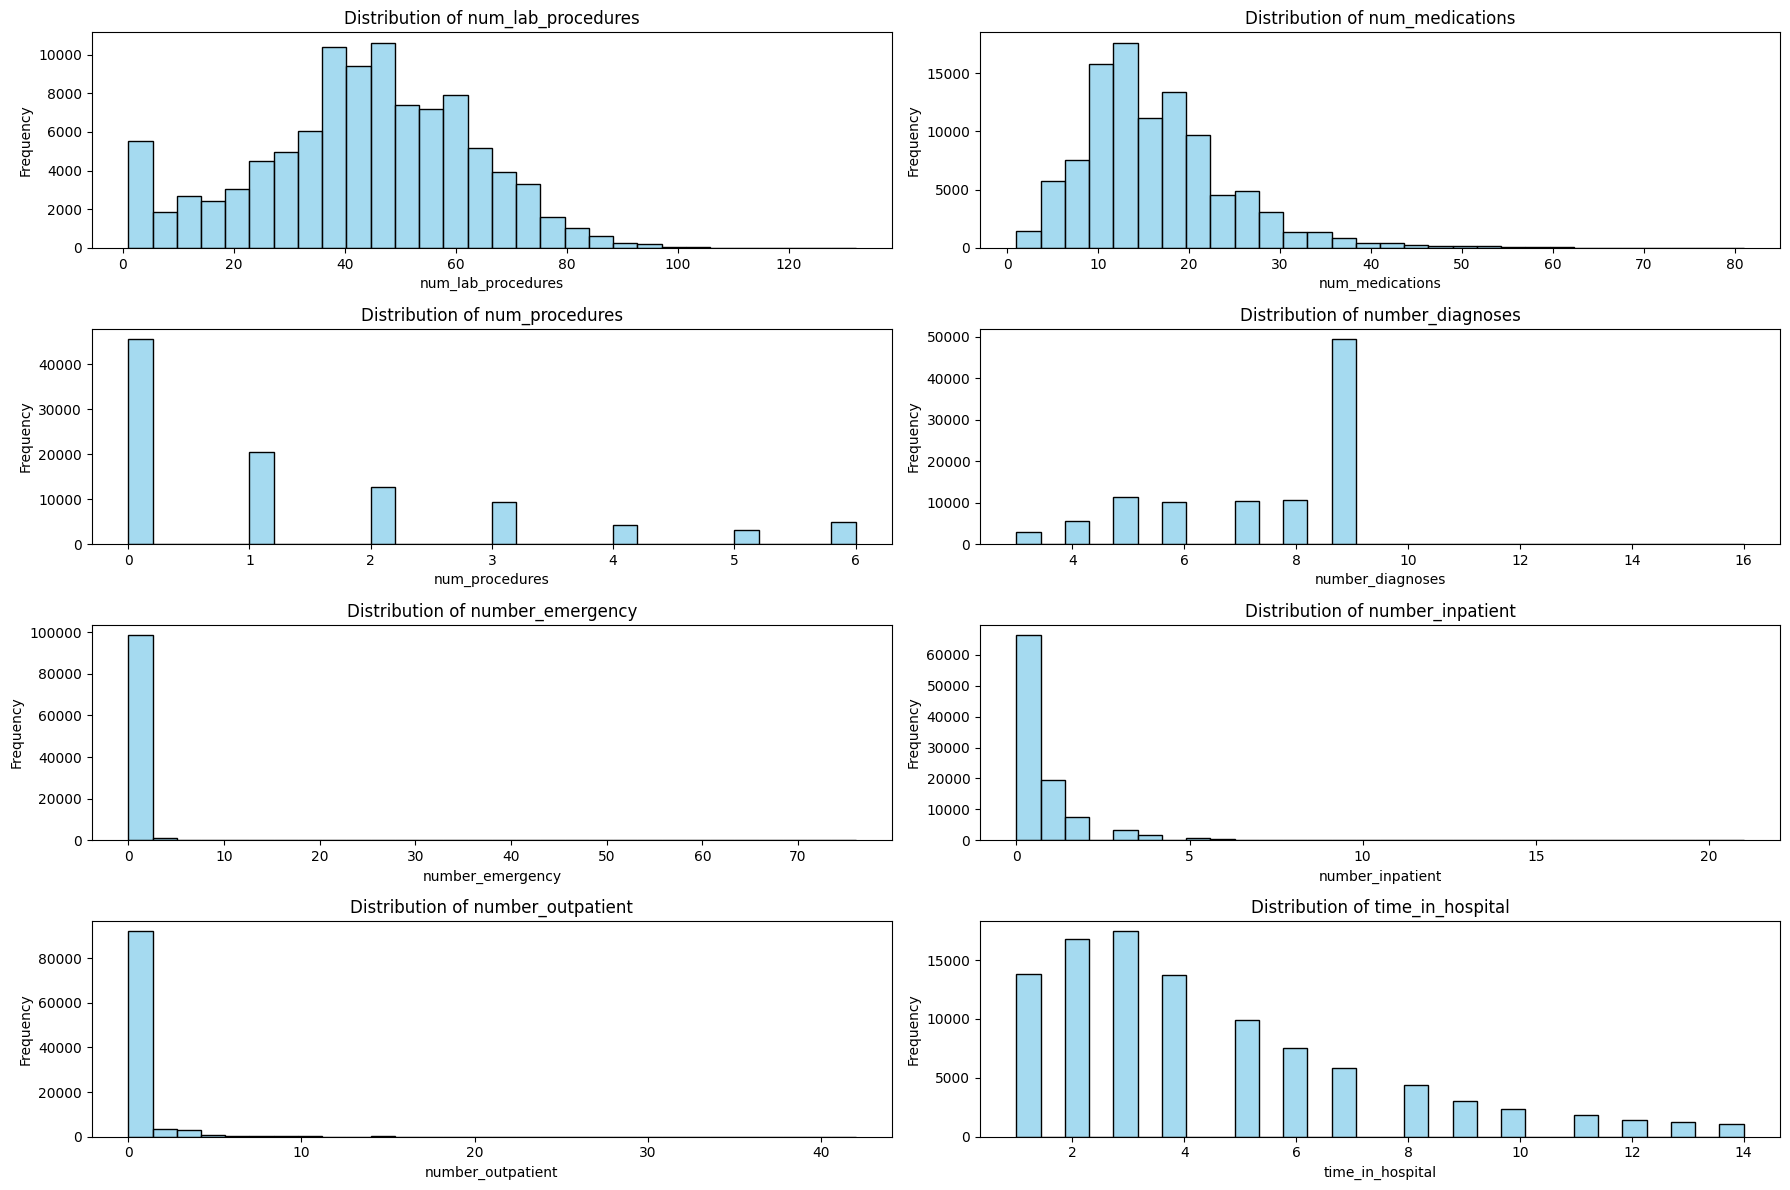

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(18, 12))

# Loop through each column and create a histogram
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(4, 2, i)  # 3 rows, 3 columns, ith plot
    sns.histplot(diabetic_data_final_filled_cleaned[column], color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.xlabel(column)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [18]:
non_outlier_diabetic_data = diabetic_data_final_filled_cleaned.copy()

# Removing outliers

outlier_columns_iqr = [
  'num_procedures', # iqr
  'number_diagnoses', # iqr
  'time_in_hospital', # iqr
]

q_range = 0.25
iqr_range = 1.5
for column in outlier_columns_iqr:
    Q1 = diabetic_data_final_filled_cleaned[column].quantile(q_range)
    Q3 = diabetic_data_final_filled_cleaned[column].quantile(1 - q_range)
    IQR = Q3 - Q1
    non_outlier_diabetic_data = non_outlier_diabetic_data[(non_outlier_diabetic_data[column] >= (Q1 - iqr_range * IQR)) & (non_outlier_diabetic_data[column] <= (Q3 + iqr_range * IQR))]



outlier_columns_zscore = [
  'num_lab_procedures', # z-score
  'num_medications', # z-score
]

for column in outlier_columns_zscore:
  lower_range = round(diabetic_data_final_filled_cleaned[column].mean() - 3 * diabetic_data_final_filled_cleaned[column].std())
  upper_range = round(diabetic_data_final_filled_cleaned[column].mean() + 3 * diabetic_data_final_filled_cleaned[column].std())
  non_outlier_diabetic_data = non_outlier_diabetic_data[(non_outlier_diabetic_data[column] >= lower_range) & (non_outlier_diabetic_data[column] <= upper_range)]


outlier_columns_percentile = [
  'number_emergency',
  'number_inpatient',
  'number_outpatient',
]

range = 0.025
for column in outlier_columns_percentile:
  lower_range1 = diabetic_data_final_filled_cleaned[column].quantile(range)
  upper_range1 = diabetic_data_final_filled_cleaned[column].quantile(1 - range)

  non_outlier_diabetic_data = non_outlier_diabetic_data[(non_outlier_diabetic_data[column] >= (lower_range1)) & (non_outlier_diabetic_data[column] <= (upper_range1))]

non_outlier_diabetic_data.shape

(88260, 29)

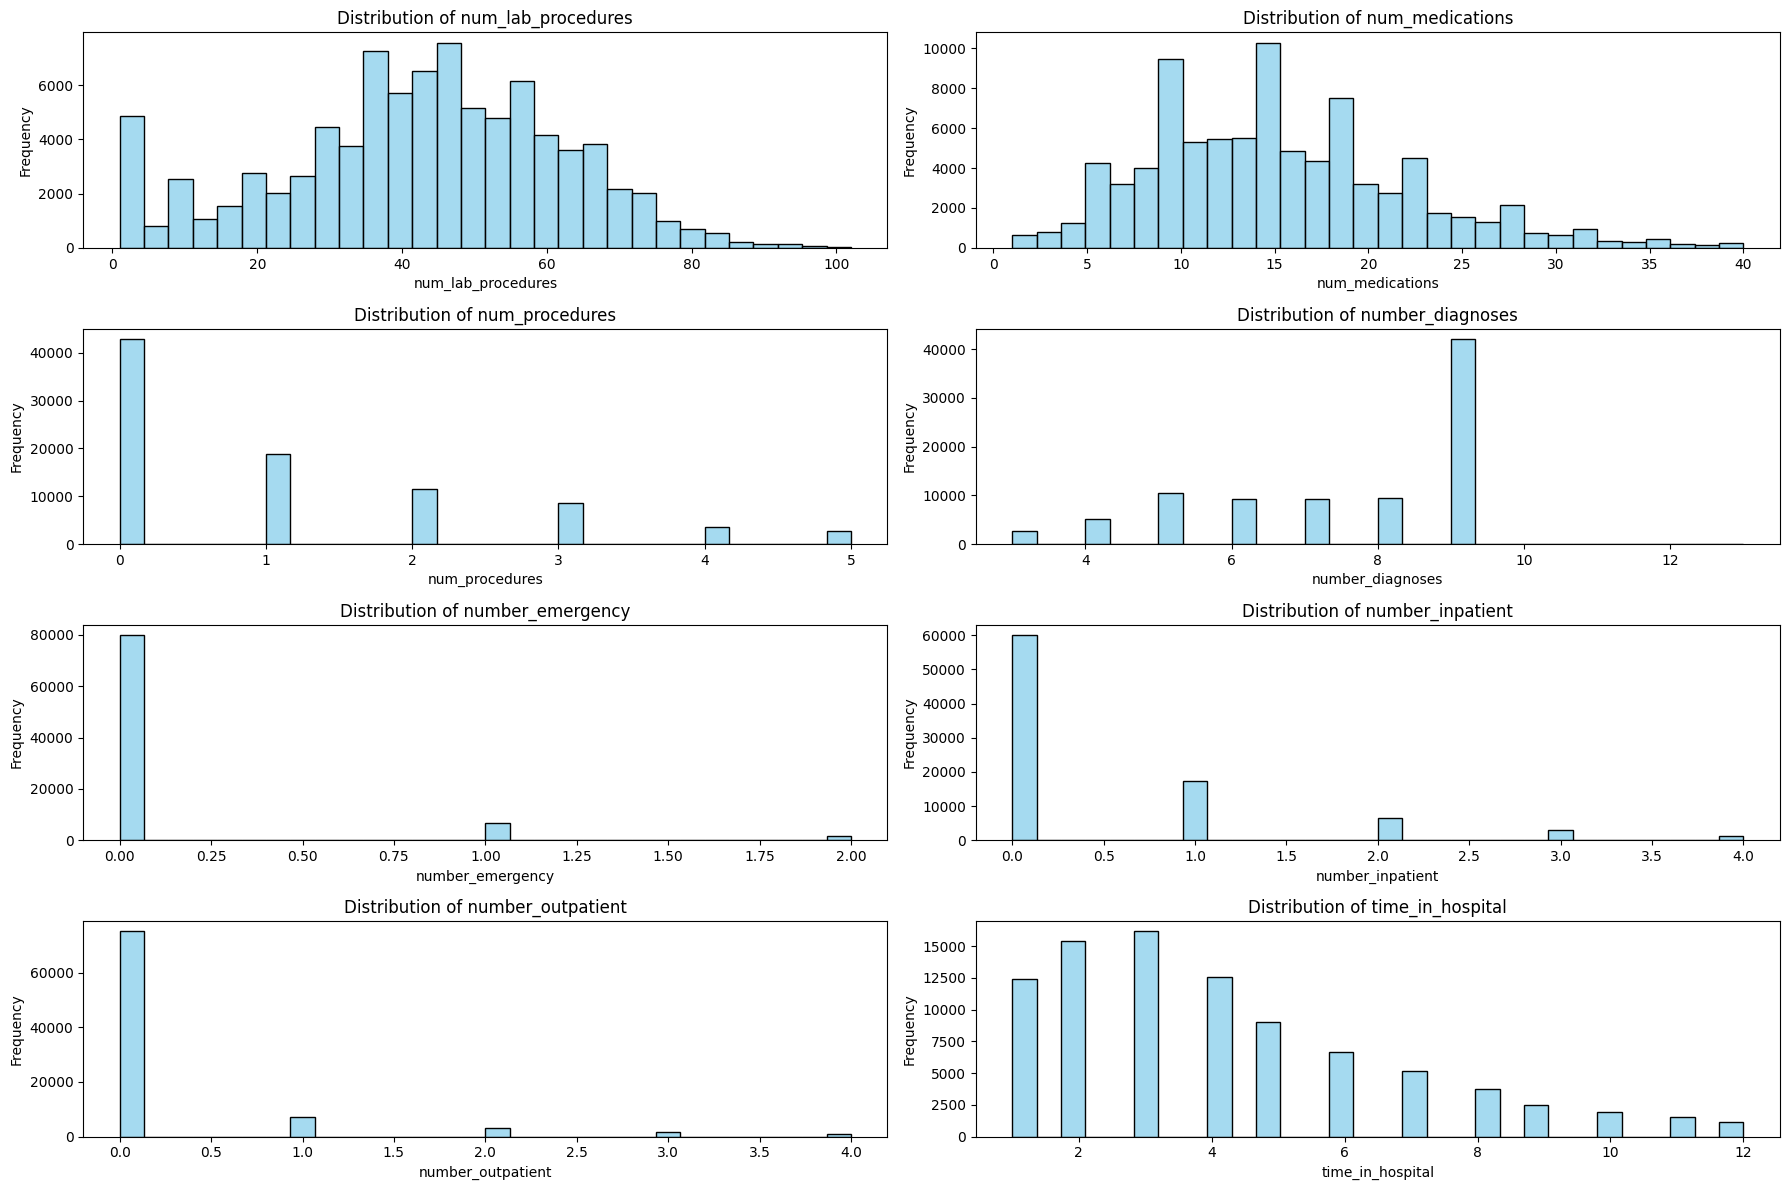

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(18, 12))

# Loop through each column and create a histogram
for i, column in enumerate(outlier_columns, 1):
    plt.subplot(4, 2, i)  # 3 rows, 3 columns, ith plot
    sns.histplot(non_outlier_diabetic_data[column], color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.xlabel(column)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


In [20]:
for col in non_outlier_diabetic_data.columns:
  if len(non_outlier_diabetic_data[col].unique()) < 10:
    print(col, non_outlier_diabetic_data[col].unique())

race ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender ['Female' 'Male' 'Unknown/Invalid']
admission_type_id [1 3 2 6 4 5 8 7]
num_procedures [0 5 1 3 2 4]
number_outpatient [0 2 1 3 4]
number_emergency [0 1 2]
number_inpatient [0 1 2 3 4]
max_glu_serum ['None' '>300' 'Norm' '>200']
A1Cresult ['None' '>7' '>8' 'Norm']
metformin ['No' 'Steady' 'Up' 'Down']
glipizide ['No' 'Steady' 'Up' 'Down']
glyburide ['No' 'Steady' 'Up' 'Down']
pioglitazone ['No' 'Steady' 'Down' 'Up']
rosiglitazone ['No' 'Steady' 'Up' 'Down']
insulin ['Up' 'No' 'Steady' 'Down']
change ['Ch' 'No']
diabetesMed ['Yes' 'No']
readmitted [0 1]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(18, 300))

# Loop through each column and create a histogram
for i, column in enumerate(non_outlier_diabetic_data.columns, 1):
    plt.subplot(30, 2, i)  # 3 rows, 3 columns, ith plot
    sns.histplot(non_outlier_diabetic_data[column], color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.xlabel(column)

# Adjust layout for better readability
plt.show()


In [ ]:
# Normalize 'age' column to the average of the age range
normalized_diabetic_data = non_outlier_diabetic_data.copy()

for col in ["metformin", "glipizide", "glyburide", "pioglitazone", "rosiglitazone", "insulin"]:
    normalized_diabetic_data[col] = normalized_diabetic_data[col].apply(
      lambda x : 10 if x == 'Up' else ( -10 if x == 'Down' else ( 0 if x == 'Steady' else  -20))
    )

normalized_diabetic_data['A1Cresult'] = normalized_diabetic_data['A1Cresult'].apply(
  lambda x : 7 if x == '>7' else (8 if  x == '>8' else ( 5 if x == 'Norm' else  0))
)

normalized_diabetic_data['change'] = normalized_diabetic_data['change'].apply(
  lambda x : 1 if x == 'Ch' else -1
)

normalized_diabetic_data['diabetesMed'] = normalized_diabetic_data['diabetesMed'].apply(
  lambda x : -1 if x == 'No' else 1
)

normalized_diabetic_data['max_glu_serum'] = normalized_diabetic_data['max_glu_serum'].apply(
  lambda x : 200 if x == '>200' else ( 300 if x == '>300' else ( 100 if x == 'Norm' else  0))
)

normalized_diabetic_data['age'] = normalized_diabetic_data['age'].apply(
    lambda x: np.mean([int(age) for age in x.strip('[)').split('-')])
)

normalized_diabetic_data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for better readability
plt.figure(figsize=(18, 300))

# Loop through each column and create a histogram
for i, column in enumerate(normalized_diabetic_data.columns, 1):
    plt.subplot(30, 2, i)  # 3 rows, 3 columns, ith plot
    sns.histplot(normalized_diabetic_data[column], color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.xlabel(column)

# Adjust layout for better readability
plt.show()

In [ ]:
# # Scatter matrix of numerical columns
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# numerical_columns = normalized_diabetic_data.select_dtypes(include=[np.number]).columns
# normalized_diabetic_data[numerical_columns] = scaler.fit_transform(normalized_diabetic_data[numerical_columns])

# sns.pairplot(normalized_diabetic_data[numerical_columns])
# plt.title('Scatter Matrix of Numerical Columns')
# plt.show()

In [ ]:
normalized_diabetic_data.to_csv('out.csv', index=False)